In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

## load path
import os
import sys
sys.path.append('../')
sys.path.append('../models')
from pathlib import Path

## load utils 
from util.util import *
from util.true_gaussian_process_seq import *
from util.ofm_OT_likelihood_seq_mino import *
from util.metrics import *
import time

## load modules 
from models.mino_transformer import MINO
from models.mino_modules.decoder_perceiver import DecoderPerceiver
from models.mino_modules.encoder_supernodes_gno_cross_attention import EncoderSupernodes
from models.mino_modules.conditioner_timestep import ConditionerTimestep

## Parameters

In [2]:
n_x = 64
dims = [n_x, n_x]
query_dims = [n_x//4, n_x//4]
x_dim = 2

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
spath = Path('./saved_models/MINO_T_NS')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# GP hyperparameters
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default

# model hyperparameters
## conditional time step.. 
dim = 256
num_heads=4

## training parameters
epochs = 300
sigma_min=1e-4 
batch_size = 96

### Dataset and Dataloder

`x_train` : contains N samples, with shape (N, n_chan, n_seq), where `n_seq` is the number of discretizations

`pos_data` : (N, x_dim, n_seq), `x_dim` is the dimension for the domain, for 2D `x_dim` = 2

`query_pos` : inquired position for GNO, has a shape of (x_dim, n_node). n_node << n_seq. 

In [3]:
x_train = np.load('../dataset/N_S/ns_30000.npy')
x_train = torch.flatten(torch.Tensor(x_train), start_dim=2)

n_pos = make_2d_grid(dims) #64x64 
pos_data = n_pos.unsqueeze(0).repeat(len(x_train), 1, 1).permute(0,2,1) 

query_pos = make_2d_grid(query_dims).permute(1,0) #[2, 16x16]
train_dataset = SimDataset(x_train, pos_data, query_pos)

loader_tr =  DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=SimulationCollator,
)

## Model Initialization

In [ ]:
conditioner = ConditionerTimestep(
    dim=dim
)
model = MINO(
    conditioner=conditioner,
    encoder=EncoderSupernodes(
        input_dim=1, # co-domain 
        ndim=2, # dimension of domain
        radius= 0.07,
        enc_dim=dim,
        enc_num_heads=num_heads,
        enc_depth=5,
        cond_dim=conditioner.cond_dim,
    ),
    decoder=DecoderPerceiver(
        input_dim=dim,
        output_dim=1,
        ndim=2,
        dim=dim,
        num_heads=num_heads,
        depth=2, # 2 layers
        unbatch_mode="dense_to_sparse_unpadded",
        cond_dim=conditioner.cond_dim,
    ),
)
model = model.to(device)
#print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

In [5]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)
fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, x_dim=x_dim, n_pos=n_pos)

In [24]:
fmot.train(loader_tr, optimizer, epochs=epochs, scheduler=scheduler, eval_int=int(0), save_int=int(300), generate=False, save_path=spath,saved_model=saved_model)

## Evaluation 

In [7]:
# load the trained model
for param in model.parameters():
    param.requires_grad = False
    
model_path = os.path.join(spath, 'epoch_300.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint, strict=False)
fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, x_dim=x_dim, n_pos=n_pos)


In [8]:
# load test dataset 
x_test = np.load('../dataset/N_S/ns_test_10000.npy')
x_test = torch.Tensor(x_test)
x_test = x_test[:5000] # keep first 5000 test sample


In [9]:
def gen_meta_info(batch_size, dims, query_dims):

    n_pos = make_2d_grid(dims)  
    pos_data = n_pos.unsqueeze(0).repeat(batch_size, 1, 1)
    
    query_n_pos = make_2d_grid(query_dims) # unchanged
    query_pos_data = query_n_pos.unsqueeze(0).repeat(batch_size, 1, 1)

    collated_batch = {}

    collated_batch["input_pos"] = pos_data.permute(0, 2, 1)
    collated_batch['query_pos']= query_pos_data.permute(0, 2, 1)
    
    return collated_batch

In [10]:
start = time.time()

In [ ]:
with torch.no_grad():


    collated_batch =  gen_meta_info(batch_size=10, dims=dims, query_dims=query_dims)
    pos, query_pos = collated_batch['input_pos'], collated_batch['query_pos']
    X_hat = fmot.sample(pos=pos.to(device), query_pos=query_pos.to(device), n_samples=10, n_eval=10).cpu()
    X_hat = X_hat.reshape(X_hat.shape[0], *dims)
    
    X_ground_truth = x_test[:5].squeeze()
    # plot
    
    X_alt = []
    # generate 5000 synthetic samples
    for i in range(25):
        collated_batch =  gen_meta_info(batch_size=200, dims=dims, query_dims=query_dims)
        pos, query_pos = collated_batch['input_pos'], collated_batch['query_pos']
        X_temp = fmot.sample(pos=pos.to(device), query_pos=query_pos.to(device), n_samples=200, n_eval=2).cpu()
    
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt).squeeze()
    
    X_alt = X_alt.reshape(X_alt.shape[0], *dims)

    
    bin_center, x_acovf = compute_acovf(X_alt.squeeze())
    _, x_acovf_true = compute_acovf(x_test.squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)
    x_hist_true, bin_edges = x_test.histogram(range=[-4, 4], density=True)
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x,cmap="RdBu_r")#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth,cmap="RdBu_r")#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('Ground Truth', fontsize=16)

   
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(bin_center, x_acovf_true, c='k', lw=3, label='Ground Truth')
    ax.plot(bin_center, x_acovf, c='r',ls='--', lw=3, label='OFM')
    ax.set_title('Autocovariance')
    ax.set_xlabel('Number of lags')
    ax.legend(loc='upper right')

In [ ]:
end = time.time()
print(end-start)

## metrics

In [13]:
# For fluid
hist_mse = torch.mean((x_hist_true - x_hist)**2)

cov_mse = np.mean((x_acovf_true[~np.isnan(x_acovf_true)] - x_acovf[~np.isnan(x_acovf)])**2)

true_spect = spectrum_2d(torch.Tensor(x_test), 64)
spect = spectrum_2d(X_alt, 64)
spect_mse = torch.mean((true_spect - spect)**2)

In [14]:
## general metric 
swd_value = swd_stable(X=X_alt, Y=x_test)
mmd_value = unbiased_mmd2_torch(X=X_alt, Y=x_test, device=device)  

In [23]:
print('hist_mes:{},  \ncov_mse:{}, \nspect_mse:{}, \nswd:{:.2f}, mmd:{:.2f}'.format(hist_mse, cov_mse, spect_mse, swd_value, mmd_value))

## zero-shot super-resolution

In [ ]:
dims_sup = [128, 128]

In [ ]:
n_pos_sup = make_2d_grid(dims_sup)
pos_data_sup = n_pos_sup.unsqueeze(0).repeat(10, 1, 1).permute(0,2,1)

In [ ]:
with torch.no_grad():

    collated_batch =  gen_meta_info(batch_size=10, dims=dims_sup, query_dims=query_dims)
    pos, query_pos = collated_batch['input_pos'], collated_batch['query_pos'] # latent query is unchanged
    X_hat = fmot.sample(pos=pos.to(device), query_pos=query_pos.to(device), n_samples=10, n_eval=10).cpu()
    X_hat = X_hat.reshape(X_hat.shape[0], *dims_sup)


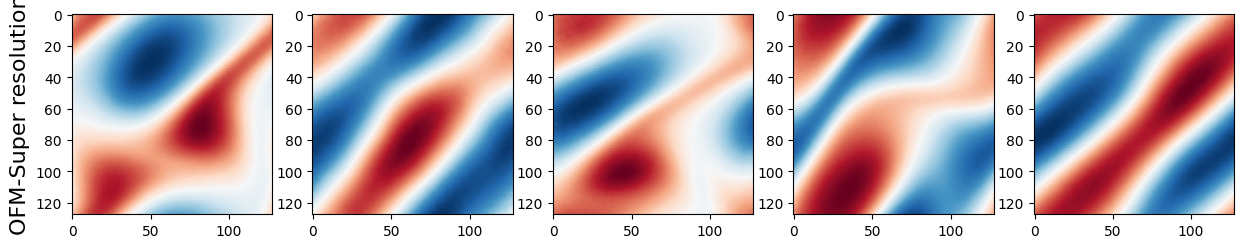

In [19]:
with torch.no_grad():

    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x,cmap="RdBu_r")#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM-Super resolution', fontsize=16)
        
